In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import warnings

# Ignore a bunch of Arviz/pymc3 deprecated warnings
warnings.filterwarnings('ignore')

## Small Dataset and Flat Priors

In the context of the next model, the data comes from a normal distribution with mean $0$ and variance $1$. However, we choose the priors of these parameters to be $\mu \sim N(0, 1000)$ and $\sigma \sim \text{Exp}(\lambda = 0.0001)$. Note that the mean of the exponential distribution with parameter $\lambda$ is $1 / \lambda$ and so a small $\lambda$ value indicates a potentially large expected value. 

### Code 9.22

In [2]:
# assume that y_obs are two observations from a Gaussian dist with mean 0 and var = 1 
y_obs = np.array([-1, 1])

with pm.Model() as m_9_2:
    alpha = pm.Normal('alpha', mu=0, sigma=1000)
    sigma = pm.Exponential('sigma', lam=0.0001)
    mu = alpha
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y_obs)
    
    trace_9_2 = pm.sample(500, tune=1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 3 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45869215805645314, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Code 9.23

In [3]:
az.summary(trace_9_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8.829,406.683,-527.505,666.502,19.858,18.590,505.0,337.0,1.09
sigma,716.506,1353.255,31.503,1692.452,99.929,70.773,19.0,49.0,1.13


## Intermediate Discussion

The values of $\alpha$ and $\sigma$ are very far off from what we expect. The `ess_tail` diagnostic shows that there were very few effective samples. The `r_hat` values are above $1$ indicating problems with convergence. 

## Prior Distributions

### Exponential Distribution

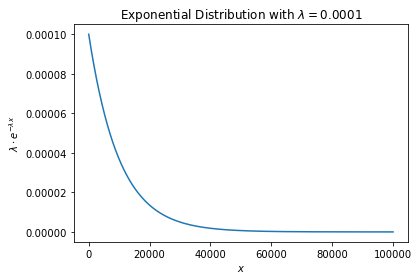

In [4]:
from scipy.stats import expon


lam = 0.0001
scale = 1/lam

x_vals = np.arange(0, 100000, 25)
y_vals = [expon.pdf(x, scale=scale) for x in x_vals]

plt.xlabel(r'$x$')
plt.ylabel(r'$\lambda \cdot e^{- \lambda x}$')
plt.title(fr'Exponential Distribution with $\lambda = {lam}$')
plt.plot(x_vals, y_vals);

### Normal Distribution

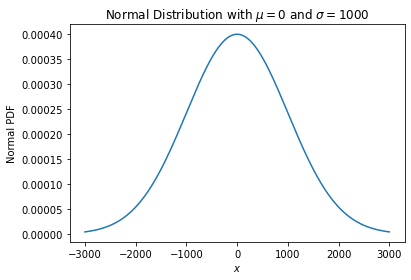

In [5]:
from scipy.stats import norm


mu = 0
sigma = 1000

x_vals = np.arange(-3000.0, 3000.0, 1)
y_vals = [norm.pdf(x, loc=mu, scale=sigma) for x in x_vals]

plt.xlabel(r'$x$')
plt.ylabel('Normal PDF')
plt.title(fr'Normal Distribution with $\mu = {mu}$ and $\sigma = {sigma}$')
plt.plot(x_vals, y_vals);

## Trace Plots

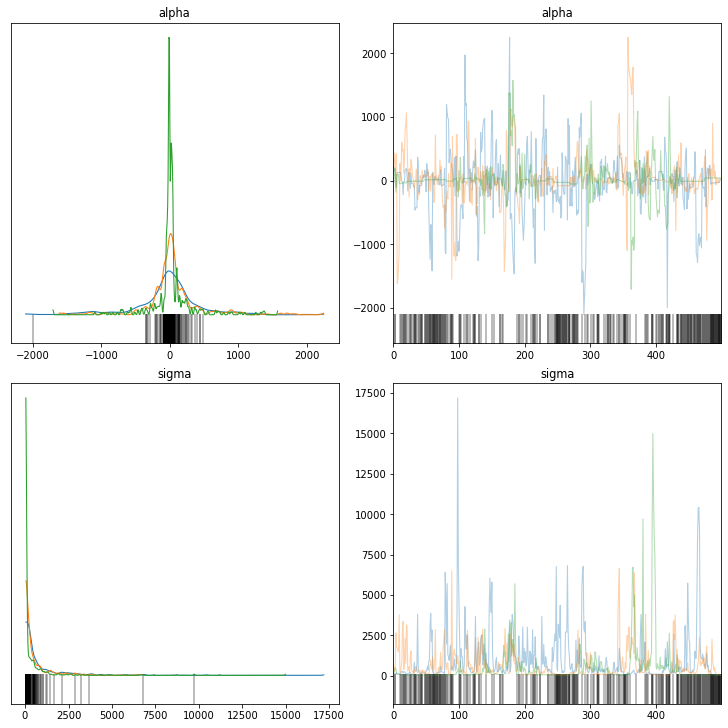

In [6]:
az.plot_trace(trace_9_2, figsize=[10, 10], compact=False);

## Trank Plots

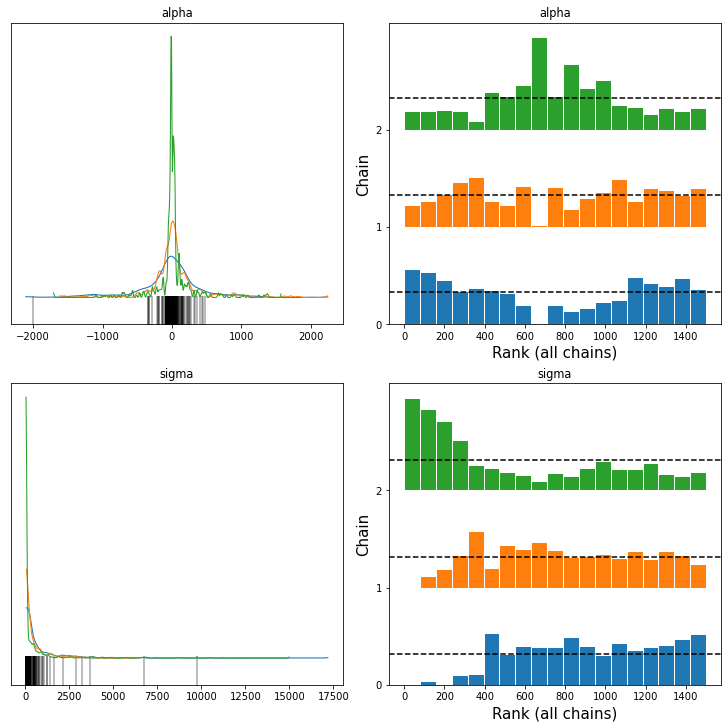

In [7]:
az.plot_trace(trace_9_2, figsize=[10, 10], compact=False, kind='rank_bars');

## Using Weakly Informative Priors Instead of Flat Priors

In what follows, we change the prior of $\mu$ to $N(1, 10)$ and that of $\sigma$ to $\text{Exp}(\lambda=1)$.  

### Code 9.24

In [8]:
with pm.Model() as m_9_3:
    alpha = pm.Normal('alpha', mu=1, sigma=10)
    sigma = pm.Exponential('sigma', lam=1)
    mu = alpha
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y_obs)
    
    trace_9_3 = pm.sample(500, tune=1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 2 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
az.summary(trace_9_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.003,1.339,-1.997,2.132,0.075,0.055,361.0,349.0,1.01
sigma,1.612,0.925,0.478,2.744,0.041,0.029,453.0,550.0,1.01


## $\S$ Trace and Trank Plots

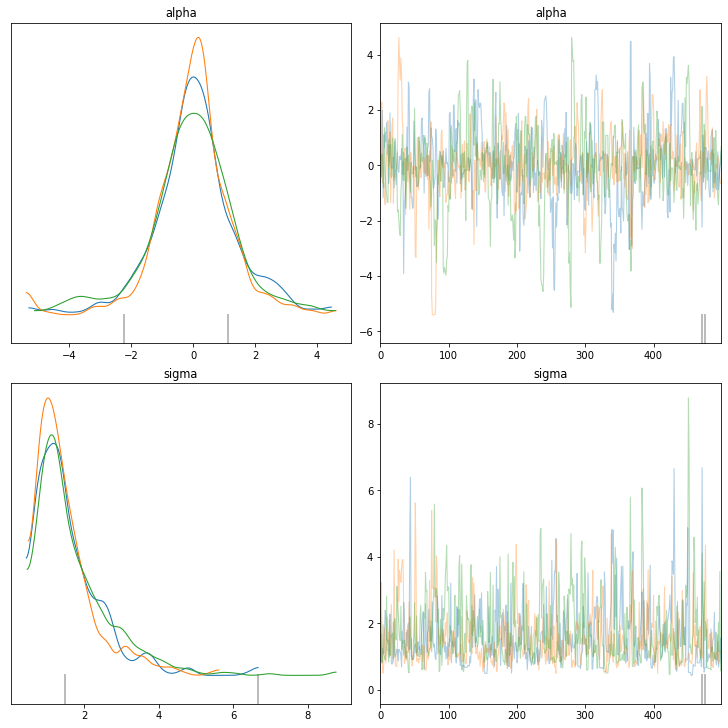

In [10]:
az.plot_trace(trace_9_3, figsize=[10, 10], compact=False);

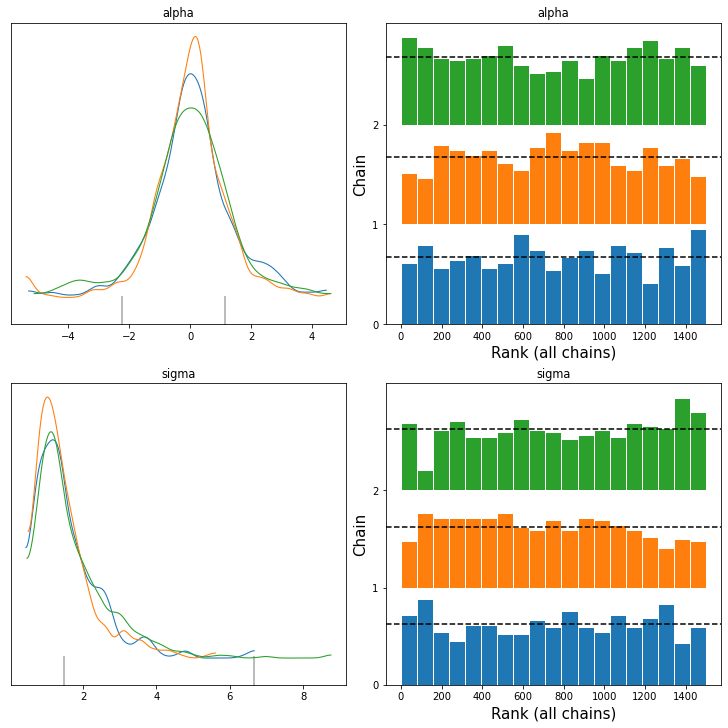

In [11]:
az.plot_trace(trace_9_3, figsize=[10, 10], compact=False, kind='rank_bars');

## $\S$ Priors and Posteriors in Model m_9_3

Adapated from: https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_09.ipynb

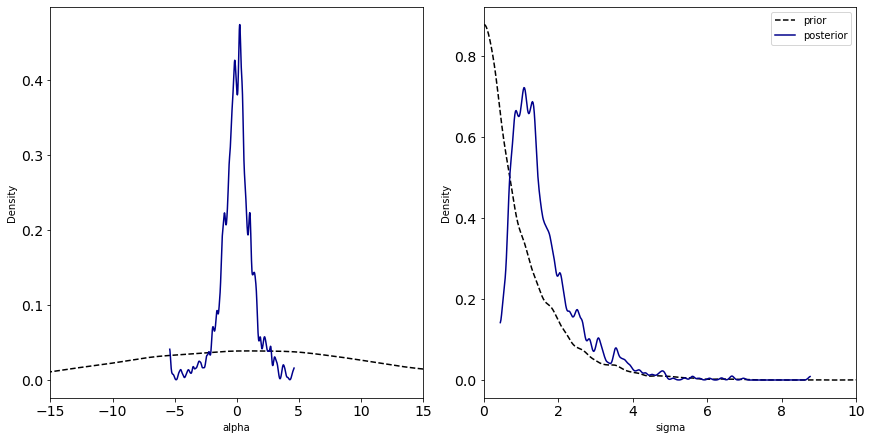

In [12]:
NUM_SAMPLES = int(1e4)
var_names = ['alpha', 'sigma']

with m_9_3:
    m_9_3_prio = pm.sample_prior_predictive(NUM_SAMPLES, var_names=var_names)
    m_9_3_post = pm.sample_posterior_predictive(trace_9_3, NUM_SAMPLES, var_names=var_names)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 6], constrained_layout=True)

az.plot_kde(m_9_3_prio['alpha'], ax=ax0, plot_kwargs={'color': 'k', 'ls': 'dashed'})
az.plot_kde(m_9_3_post['alpha'], ax=ax0, plot_kwargs={'color': 'darkblue'})

ax0.set_xlim(-15, 15)
ax0.set_xlabel('alpha')

az.plot_kde(m_9_3_prio['sigma'], ax=ax1, plot_kwargs={'color': 'k', 'ls': 'dashed'}, label='prior')
az.plot_kde(m_9_3_post['sigma'], ax=ax1, plot_kwargs={'color': 'darkblue'}, label='posterior')

ax1.legend()
ax1.set_xlim(0, 10)
ax1.set_xlabel('sigma')

for ax in (ax0, ax1):
    ax.set_ylabel('Density');

## $\S$ Conclusion

`Lots of problematic chains want subtle priors like these, designed to tune estimation by assuming a tiny bit of prior information about each parameter. And even though the priors end up getting washed out right away--two observations are enough here--they still have a big effect on inference ...` [Chapter 9]

# $\S$ Non-Identifiable Parameters 

In [13]:
from scipy.stats import norm


y_vals = norm.rvs(loc=0, scale=1, size=100)

In [14]:
with pm.Model() as m_9_4:
    a1 = pm.Normal('a1', mu=0, sigma=1000)
    a2 = pm.Normal('a2', mu=0, sigma=1000)
    mu = a1 + a2
    sigma = pm.Exponential('sigma', lam=1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y_vals)
    
    trace_9_4 = pm.sample(500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a2, a1]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 86 seconds.
There were 211 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20508314206858572, but should be close to 0.8. Try to increase the number of tuning steps.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1323096629413612, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5501042236591845, but should be close to 0.8. Try to increase the number of tuning st

In [15]:
az.summary(trace_9_4, var_names=['a1', 'a2', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,-289.216,598.612,-1121.511,391.389,284.955,221.732,5.0,16.0,2.46
a2,289.243,598.617,-391.328,1121.560,284.958,221.735,5.0,18.0,2.45
sigma,1.069,0.049,1.012,1.118,0.019,0.014,6.0,11.0,2.03


## $\S \S$ Trace Plots

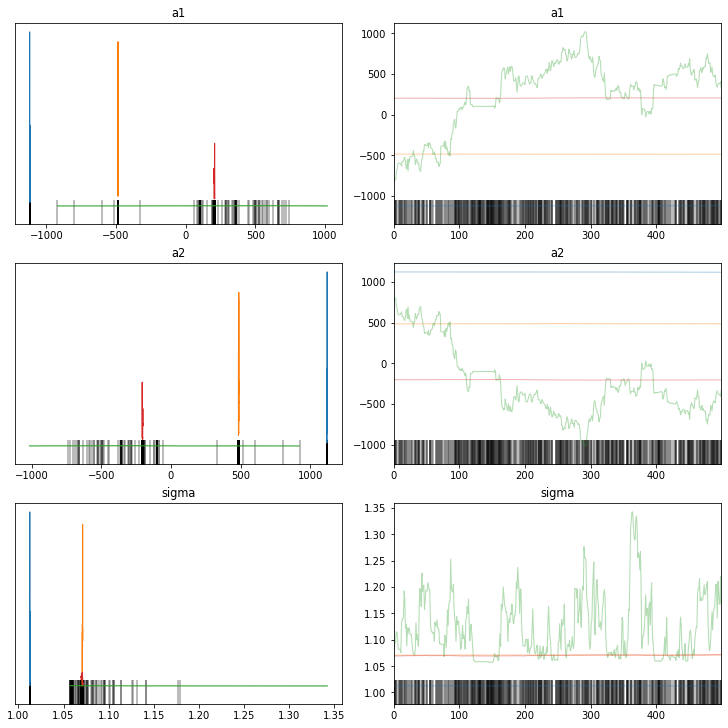

In [16]:
az.plot_trace(trace_9_4, figsize=[10, 10], compact=False);

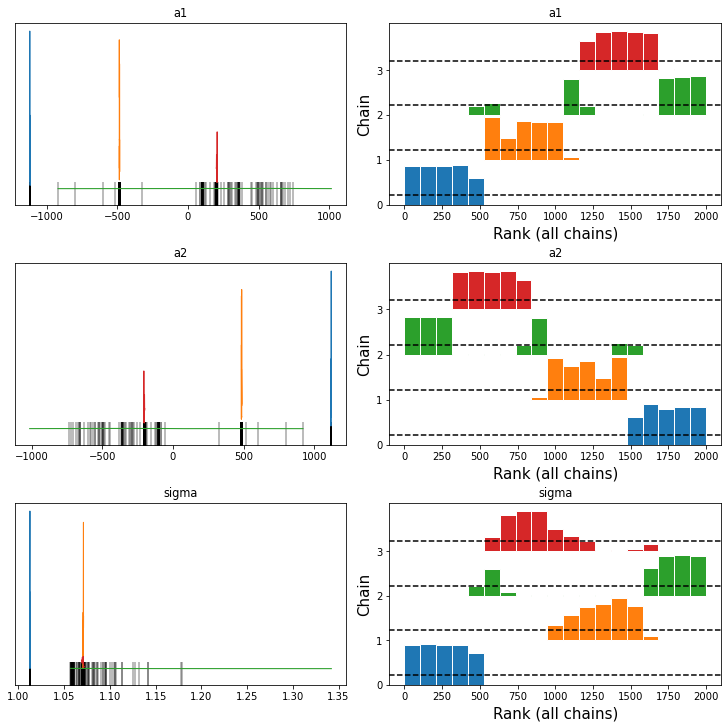

In [17]:
az.plot_trace(trace_9_4, figsize=[10, 10], compact=False, kind='rank_bars');

## $\S \S$ Weakly Regularizing Priors

In [18]:
with pm.Model() as m_9_5:
    a1 = pm.Normal('a1', mu=0, sigma=5)
    a2 = pm.Normal('a2', mu=0, sigma=5)
    mu = a1 + a2
    sigma = pm.Exponential('sigma', lam=1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y_vals)
    
    trace_9_5 = pm.sample(500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a2, a1]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.8906205582422497, but should be close to 0.8. Try to increase the number of tuning steps.


In [19]:
az.summary(trace_9_5, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.071,3.518,-5.625,5.736,0.157,0.112,500.0,563.0,1.01
a2,-0.031,3.520,-5.956,5.438,0.157,0.112,501.0,526.0,1.01
sigma,1.085,0.077,0.954,1.196,0.003,0.002,642.0,403.0,1.01


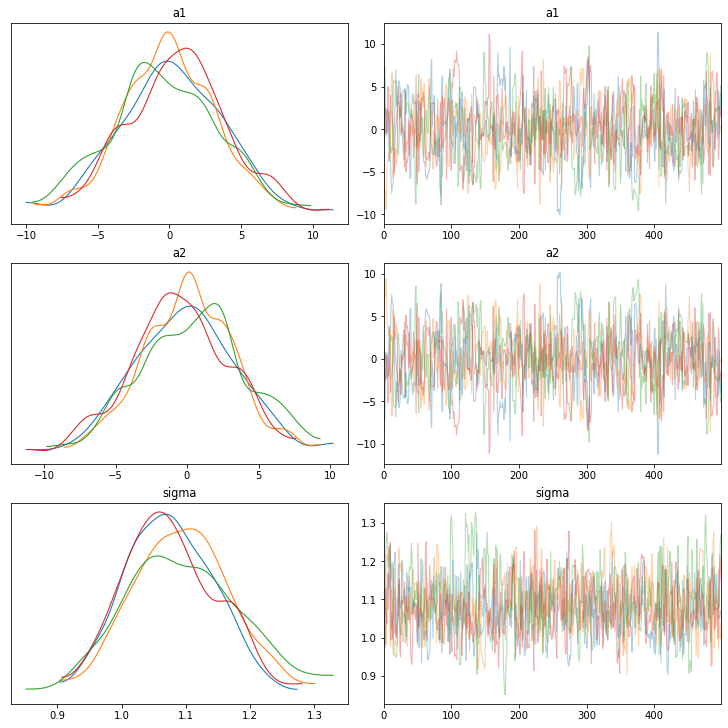

In [20]:
az.plot_trace(trace_9_5, figsize=[10, 10], compact=False);

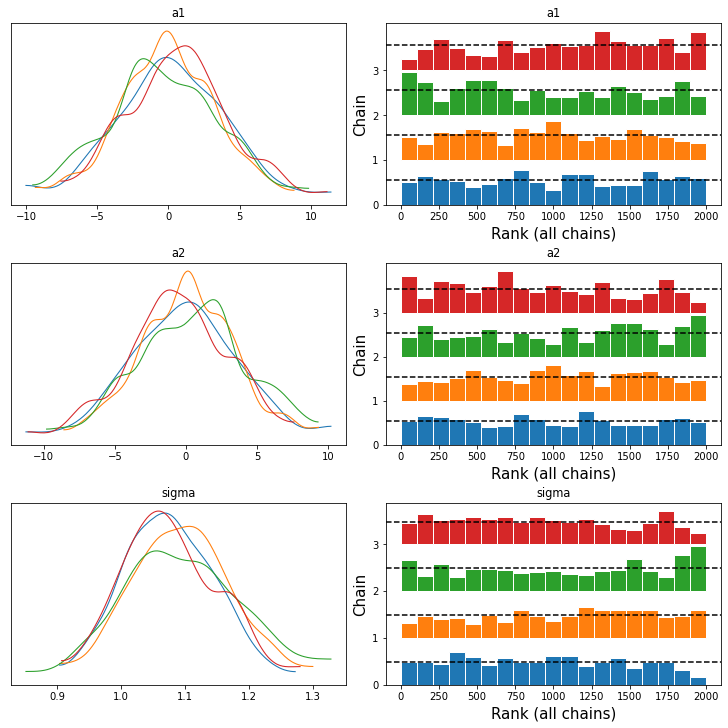

In [21]:
az.plot_trace(trace_9_5, figsize=[10, 10], compact=False, kind='rank_bars');